In [13]:

import pandas as pd
import numpy as np
import pickle
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import scipy.fftpack as fftpack
from scipy.stats import binned_statistic

import argparse
import glob
from datetime import datetime

import F21DataLoader as dl


y_pred: [[ 0.82 -0.25]
 [ 0.82  0.3 ]
 [ 0.7  -1.2 ]
 [ 0.5  -0.65]]
y_test: [[ 0.8  0. ]
 [ 0.8  0. ]
 [ 0.6 -1. ]
 [ 0.6 -1. ]]
R2 Score: [0.48000000000000076, 0.685]
rmse : (4,)
[ 8.75 10.   35.   42.5 ]
Describing test data with rmse:        actual_xHI  actual_logfX  pred_xHI  pred_logfX       rmse
count     4.00000       4.00000  4.000000    4.000000   4.000000
mean      0.70000      -0.50000  0.710000   -0.450000  24.062500
std       0.11547       0.57735  0.150997    0.633772  17.241393
min       0.60000      -1.00000  0.500000   -1.200000   8.750000
25%       0.60000      -1.00000  0.650000   -0.787500   9.687500
50%       0.70000      -0.50000  0.760000   -0.450000  22.500000
75%       0.80000       0.00000  0.820000   -0.112500  36.875000
max       0.80000       0.00000  0.820000    0.300000  42.500000
Describing data with rmse:        actual_xHI  actual_logfX  pred_xHI  pred_logfX       rmse   agg_rmse
count     4.00000       4.00000  4.000000    4.000000   4.000000   4.0000

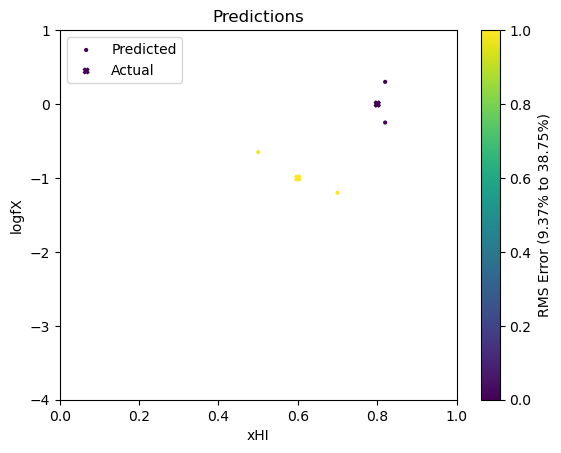

In [20]:
def summarize_test(y_pred, y_test):
    print(f"y_pred: {y_pred}")
    print(f"y_test: {y_test}")
    # Calculate R2 scores
    r2 = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(2)]
    print("R2 Score: " + str(r2))

    # Calculate rmse scores
    rmse = np.sqrt((y_test - y_pred) ** 2)
    rmse = 100*(rmse[:,0]+rmse[:,1]/5)/(y_test[:,0]+y_test[:,1]/5) # Weighted as per the range of params
    print(f"rmse : {rmse.shape}\n{rmse[:10]}")
    df_y = pd.DataFrame()
    df_y = df_y.assign(actual_xHI=y_test[:,0])
    df_y = df_y.assign(actual_logfX=y_test[:,1])
    df_y = df_y.assign(pred_xHI=y_pred[:,0])
    df_y = df_y.assign(pred_logfX=y_pred[:,1])
    df_y = df_y.assign(rmse=rmse)
    print(f"Describing test data with rmse: {df_y.describe()}")

    df_y_agg = df_y.groupby(["actual_xHI", "actual_logfX"])['rmse'].mean()
    df_y_agg.rename('agg_rmse', inplace=True)
    df_y = df_y.merge(df_y_agg, on=['actual_xHI', 'actual_logfX'], validate='many_to_one')
    print(f"Describing data with rmse: \n{df_y.describe()}\n{df_y.head()}")

    rmse_summary = df_y.groupby(["actual_xHI", "actual_logfX"])['agg_rmse'].mean()
    print(f"rmse Summary: \n{rmse_summary}")

    #print(df_y.head(5))
    cmap = plt.get_cmap('viridis')
    rmse = df_y['agg_rmse']
    rmse_min = rmse.min()
    rmse_max = rmse.max()
    norm = plt.Normalize(rmse.min(), rmse.max())
    colors = cmap(norm(rmse))    

    plt.scatter(df_y['pred_xHI'], df_y['pred_logfX'], marker="o", s=4, label='Predicted', c=colors)
    plt.scatter(df_y['actual_xHI'], df_y['actual_logfX'], marker="X", s=16, label='Actual', c=colors)
    plt.xlim(0, 1)
    plt.ylim(-4, 1)
    plt.xlabel('xHI')
    plt.ylabel('logfX')
    plt.title('Predictions')
    plt.legend()
    plt.colorbar(label=f'RMS Error ({rmse_min:.2f}% to {rmse_max:.2f}%)')
    #plt.savefig(f'output/f21_prediction.png')
    plt.show()

summarize_test(np.array([
    [0.82, -0.25], 
    [0.82, 0.3], 
    [0.7, -1.2], 
    [0.5, -0.65]]), 
    np.array([
        [0.8, 0.0], 
        [0.8, 0.0], 
        [0.6, -1.0], 
        [0.6, -1.0]]))

In [ ]:
with open('alldatafiles.txt', 'r') as file:
    all_files = file.readlines()
    # Remove any whitespace/newlines
    all_files = [f.strip() for f in all_files]

# Split into train and test sets
train_files, test_files = train_test_split(all_files, test_size=16, random_state=42)
print('\n'.join(test_files))


F21_noisy_21cmFAST_200Mpc_z6.0_fX-1.80_xHI0.35_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.80_xHI0.11_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.60_xHI0.70_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.60_xHI0.14_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.60_xHI0.44_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX1.00_xHI0.25_uGMRT_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.60_xHI1.00_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-0.80_xHI0.79_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-3.60_xHI0.35_uGMRT_8kHz_t500h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.20_xHI0.35_SKA1-low_8kHz_t50h_Smin64.2mJy_alphaR-0.44.dat
F21_noisy_21cmFAST_200Mpc_z6.0_fX-2.20_xHI0.80_uGMRT_8kHz_t50h_Smin64.2m